Trabajo Grupal

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

c:\Users\Eduio\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
url = "https://raw.githubusercontent.com/eduardo-cavero/Diplomado_PUCP_2025-1/e06c22ddeeb3a419673d31bda46abd7b7109f923/Machine%20Learning/BD_FINAL.csv"
df = pd.read_csv(url)
df.head()


,municipalidad,2017_corrupcion,2018_corrupcion,2019_corrupcion,2020_corrupcion,2021_corrupcion,2022_corrupcion,2023_corrupcion,2024_corrupcion,2017_IDH,...,2023_PIM,2024_PIM,2017_Devengado,2018_Devengado,2019_Devengado,2020_Devengado,2021_Devengado,2022_Devengado,2023_Devengado,2024_Devengado
0,AMAZONAS_BAGUA,1,2,3,1,4,2,2,2,0.549475,...,"30,575,495","34,351,868","15,124,989","13,507,604","13,765,469","28,386,442","31,836,250","24,084,078","23,181,870","29,690,800"
1,AMAZONAS_BONGARA,0,0,0,1,1,0,0,2,0.523778,...,"22,591,077","14,194,672","3,615,485","3,161,325","4,353,686","16,116,622","8,761,382","10,212,502","15,530,917","8,655,331"
2,AMAZONAS_CHACHAPOYAS,0,3,0,2,0,0,1,4,0.593332,...,"107,507,294","132,120,049","22,352,797","17,228,131","14,864,073","31,360,444","29,576,070","42,316,052","43,692,323","78,701,527"
3,AMAZONAS_CONDORCANQUI,0,2,5,4,1,3,2,2,0.449506,...,"48,221,148","64,789,947","23,207,806","31,814,397","34,675,427","25,168,519","32,131,549","25,352,064","37,304,364","61,573,762"
4,AMAZONAS_LUYA,0,0,1,2,0,0,1,1,0.464236,...,"21,816,629","27,819,325","23,523,008","12,704,180","14,934,339","43,810,007","32,000,931","27,394,088","19,262,390","16,951,177"


In [3]:
# --- A. Limpieza de columnas de Presupuesto (PIM y Devengado) ---

def clean_numeric_col(series):
    """Limpia espacios, remueve comas y convierte a float."""
    # Los métodos .str.strip() y .str.replace(',', '') son cruciales.
    return series.astype(str).str.strip().str.replace(',', '').astype(float)

# Identificar columnas a limpiar
pim_cols = [col for col in df.columns if 'PIM' in col]
devengado_cols = [col for col in df.columns if 'Devengado' in col]

# ESTE BLOQUE DEBE EJECUTARSE SIN FALLAS:
for col in pim_cols + devengado_cols:
    df[col] = clean_numeric_col(df[col])

# AÑADE ESTA LÍNEA DE VERIFICACIÓN:
print(df[pim_cols + devengado_cols].head(3))
print(df[pim_cols + devengado_cols].dtypes)

# --- Eficiencia en Gasto ---

# Los años van de 2017 a 2024
years = range(2017, 2025)
efficiency_cols = []

for year in years:
    pim_col = f'{year}_PIM'
    dev_col = f'{year}_Devengado'
    eff_col = f'{year}_Eficiencia_Gasto'
    
    # Calcular Eficiencia: Devengado / PIM
    # Añadimos .replace([np.inf, -np.inf], np.nan) por si PIM fuera cero
    df[eff_col] = (df[dev_col] / df[pim_col]).replace([np.inf, -np.inf], np.nan)
    efficiency_cols.append(eff_col)
    
# Rellenar cualquier NaN que pudiera surgir de la división por cero con 0 (cero eficiencia)
df[efficiency_cols] = df[efficiency_cols].fillna(0)

     2017_PIM    2018_PIM    2019_PIM    2020_PIM    2021_PIM    2022_PIM  \
0  16738156.0  15190192.0  18929899.0  46610835.0  37044392.0  28206725.0   
1   3976953.0   3270617.0  12102749.0  20444814.0  10140465.0  21825489.0   
2  29572272.0  21053950.0  20553411.0  54738256.0  39131645.0  58291087.0   

      2023_PIM     2024_PIM  2017_Devengado  2018_Devengado  2019_Devengado  \
0   30575495.0   34351868.0      15124989.0      13507604.0      13765469.0   
1   22591077.0   14194672.0       3615485.0       3161325.0       4353686.0   
2  107507294.0  132120049.0      22352797.0      17228131.0      14864073.0   

   2020_Devengado  2021_Devengado  2022_Devengado  2023_Devengado  \
0      28386442.0      31836250.0      24084078.0      23181870.0   
1      16116622.0       8761382.0      10212502.0      15530917.0   
2      31360444.0      29576070.0      42316052.0      43692323.0   

   2024_Devengado  
0      29690800.0  
1       8655331.0  
2      78701527.0  
2017_PIM         

In [4]:
# --- B. Reshape (Melt) de Wide a Long Format ---

# Añadimos 'Eficiencia_Gasto' a la lista de variables
variables = ['corrupcion', 'IDH', 'PIM', 'Devengado', 'Eficiencia_Gasto']
id_vars = ['municipalidad']
melt_dfs = []

for var in variables:
    var_cols = [col for col in df.columns if col.endswith(var)]

    df_melted = df.melt(
        id_vars=id_vars,
        value_vars=var_cols,
        var_name='year_col',
        value_name=var
    )
    df_melted['year'] = df_melted['year_col'].apply(lambda x: int(x.split('_')[0]))
    df_melted = df_melted.drop(columns='year_col')
    melt_dfs.append(df_melted)

# Fusionar los DataFrames transformados
df_long = melt_dfs[0]
for i in range(1, len(melt_dfs)):
    df_long = pd.merge(df_long, melt_dfs[i], on=['municipalidad', 'year'])

In [5]:
# --- C. Creación de la Variable Objetivo (Y_t+1) y Features (X_t) ---

df_long = df_long.sort_values(by=['municipalidad', 'year'])
df_long['target_corrupcion_next_year'] = df_long.groupby('municipalidad')['corrupcion'].shift(-1)

df_model = df_long.copy()
df_model.dropna(subset=['target_corrupcion_next_year'], inplace=True)

print(f"Número de observaciones para entrenamiento: {len(df_model)}")

features = ['corrupcion', 'IDH', 'PIM', 'Devengado', 'Eficiencia_Gasto']
target = 'target_corrupcion_next_year'

X = df_model[features]
y = df_model[target]


Número de observaciones para entrenamiento: 1613


In [6]:
# División en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,      # Número de árboles
    random_state=42,       # Semilla para reproducibilidad
    n_jobs=-1,             # Usa todos los núcleos del procesador
    max_depth=10,          # Profundidad máxima de los árboles
    min_samples_leaf=5     # Mínimo de muestras por hoja
)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

In [7]:
# 3. EVALUACIÓN Y RESULTADOS

# Predicciones en el conjunto de prueba
y_pred = rf_regressor.predict(X_test)

# Métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n3. Evaluación del Modelo:")
print(f"  - Mean Squared Error (MSE): {mse:.4f}")
print(f"  - R-squared (R^2) Score: {r2:.4f}")

# Importancia de las Características
feature_importances = pd.Series(
    rf_regressor.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

print("\nImportancia de las Características:")
print(feature_importances)


3. Evaluación del Modelo:
  - Mean Squared Error (MSE): 12.0788
  - R-squared (R^2) Score: 0.4491

Importancia de las Características:
corrupcion          0.661357
IDH                 0.100573
Devengado           0.082471
Eficiencia_Gasto    0.079419
PIM                 0.076179
dtype: float64


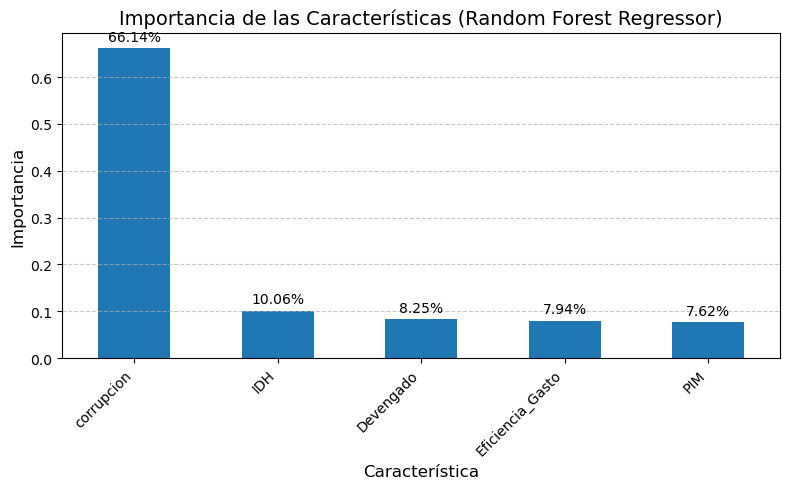

In [8]:
# 4. VISUALIZACIÓN DE LA IMPORTANCIA DE LAS CARACTERÍSTICAS

plt.figure(figsize=(8, 5))
feature_importances.plot(kind='bar', color='#1f77b4')
plt.title('Importancia de las Características (Random Forest Regressor)', fontsize=14)
plt.ylabel('Importancia', fontsize=12)
plt.xlabel('Característica', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i, v in enumerate(feature_importances):
    plt.text(i, v + 0.01, f'{v*100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show() 

In [9]:
# 5. PREDICCIÓN DE RIESGO PARA EL AÑO SIGUIENTE (Y_2025)
# --- A. Preparar los datos de entrada para la predicción (t=2024) ---

# Recrear el DataFrame 'df_long' solo con los datos de 2024
# Para esto, necesitamos volver a fusionar los DataFrames transformados, 
# pero luego enfocarnos solo en el año 2024.

# Re-ejecución simplificada de la transformación para el año 2024
# (Asumiendo que las variables 'df' original y 'variables' están en memoria)

# Aseguramos que la limpieza se haya realizado en el df original (df)
# (Si está ejecutando esto por separado, necesitaría las funciones de limpieza de nuevo)
# pim_cols y devengado_cols deben estar limpios en 'df'.

data_2024 = df[['municipalidad']].copy()
features_2024 = {}

for var in variables:
    col_2024 = f'2024_{var}'
    if col_2024 in df.columns:
        # Asegurarse de que las columnas están limpias antes de extraerlas
        if var in ['PIM', 'Devengado']:
            # Asume que 'df' ya fue limpiado en el script anterior
            data_2024[var] = df[col_2024]
        else:
            data_2024[var] = df[col_2024]
        features_2024[var] = col_2024

# Crear el DataFrame de características (X_2024)
X_2024 = data_2024[features]

In [10]:
# --- B. Generar Predicciones (Y_2025) ---

# El modelo rf_regressor debe estar entrenado en su memoria
y_pred_2025 = rf_regressor.predict(X_2024)

In [11]:
# --- C. Consolidar Resultados y Ranking ---

# Añadir las predicciones al DataFrame de 2024
data_2024['prediccion_corrupcion_2025'] = y_pred_2025

# Ordenar las municipalidades por el riesgo predicho (mayor a menor)
df_riesgo_ranking = data_2024[['municipalidad', 'prediccion_corrupcion_2025']].sort_values(
    by='prediccion_corrupcion_2025', 
    ascending=False
).round(2)

In [12]:
# Mostrar las 10 municipalidades con mayor riesgo
print("\nTop 10 Municipalidades con Mayor Riesgo de Corrupción (Predicción 2025):")
print(df_riesgo_ranking.head(10).to_markdown(index=False))


Top 10 Municipalidades con Mayor Riesgo de Corrupción (Predicción 2025):
| municipalidad           |   prediccion_corrupcion_2025 |
|:------------------------|-----------------------------:|
| TUMBES_TUMBES           |                        19.81 |
| PIURA_PAITA             |                        18.85 |
| LORETO_MAYNAS           |                        18.83 |
| ANCASH_HUARAZ           |                        18.6  |
| PUNO_SAN ROMAN          |                        18.34 |
| MADRE DE DIOS_TAHUAMANU |                        17.99 |
| CAJAMARCA_CAJAMARCA     |                        17.98 |
| PIURA_PIURA             |                        17.81 |
| JUNIN_JAUJA             |                        17.5  |
| AYACUCHO_HUAMANGA       |                        17.44 |
